# Linear Optimization

In [1]:
import pandas as pd
import os 
from mip import Model, xsum, minimize, OptimizationStatus, BINARY, GRB
import matplotlib.pyplot as plt

SYNTH_DATA_PATH = '../data'
OUT_SYNTH_DATA_PATH = '../output'

## Load Data

### Distances

In [2]:
d_matrix = pd.read_csv(os.path.join(SYNTH_DATA_PATH, 'Distance_Matrix_Synthetic.csv'), 
                       index_col=0)
d_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,0.0000,11.3769,20.4557,38.1227,45.3810,54.9915,78.6108,118.6750,102.6639,113.4309,...,683.8771,687.6310,697.3246,669.3962,667.6788,665.5775,662.0291,665.9655,673.2073,681.4235
1,11.3769,0.0000,9.0788,28.9141,36.1724,45.7829,69.4022,78.2329,93.4553,111.1832,...,681.6295,685.3833,695.0769,667.1485,665.4311,663.3298,659.7815,663.7178,670.9596,679.1758
2,20.4557,9.0788,0.0000,22.3791,29.6374,39.2478,62.8671,71.6979,86.9203,111.7859,...,682.2323,685.9861,695.6796,667.7513,666.0339,663.9326,660.3843,664.3206,671.5623,679.7786
3,38.1227,28.9141,22.3791,0.0000,11.8343,23.5413,41.8396,50.6703,65.8927,82.5852,...,681.4226,685.1765,694.8701,666.9417,665.2243,663.1230,659.5746,663.5110,670.7528,678.9690
4,45.3810,36.1724,29.6374,11.8343,0.0000,11.7070,24.3986,33.2293,53.9901,65.1442,...,663.9816,667.7355,677.4291,649.5007,647.7833,645.6820,642.1336,646.0700,653.3118,661.5280


In [3]:
df_fc = pd.read_csv(os.path.join(SYNTH_DATA_PATH, 'Biomass_History_Synthetic.csv'))
df_fc.head()

,Index,Latitude,Longitude,2018,2019
0,0,24.66818,71.33144,7.387925,5.180296
1,1,24.66818,71.41106,40.431847,42.126945
2,2,24.66818,71.49069,59.181629,73.203232
3,3,24.66818,71.57031,74.536720,101.067352
4,4,24.66818,71.64994,16.531315,26.086885


In [6]:
df_fc['Index'].max()

2417

# First Case: Depot in position 0

In a first approach, let's solve

$$
\min_{0\leq j \leq 2416} \sum_{j}(d_{j, 0} * b_{j, 0})\\
b_{j, 0} \geq 0\\
\sum_j b_{j, 0} \leq 20000\\
b_{j, 0} \leq b_{j}^{forecast}
$$

Distance to j=0:  [  0.      11.3769  20.4557 ... 663.7748 671.0165 679.2328]
Forecasted biomass for year 2018:  {0: 7.387925148, 1: 40.43184662, 2: 59.18162918, 3: 74.53672028, 4: 16.53131485, 5: 23.59261703, 6: 37.77179718, 7: 72.29115295, 8: 31.31279564, 9: 36.00815201, 10: 7.731999874, 11: 4.729420662, 12: 4.019220352, 13: 0.170855775, 14: 0.407948494, 15: 29.41272354, 16: 94.71604919, 17: 128.6074066, 18: 119.6863556, 19: 60.41845703, 20: 82.89323425, 21: 90.87753296, 22: 116.8996277, 23: 109.9925232, 24: 87.78025055, 25: 77.210495, 26: 42.75498581, 27: 27.09572029, 28: 3.248904228, 29: 0.316811502, 30: 25.035532, 31: 87.5641098, 32: 150.813324, 33: 132.3540192, 34: 117.1153717, 35: 98.37117767, 36: 166.2753143, 37: 131.4788666, 38: 102.0719376, 39: 68.13217163, 40: 87.15248108, 41: 98.95579529, 42: 89.4603653, 43: 18.38335991, 44: 1.929136515, 45: 0.109720692, 46: 0.536449432, 47: 21.13311577, 48: 79.66234589, 49: 121.5448074, 50: 106.9424896, 51: 78.92514801, 52: 104.6953964, 53

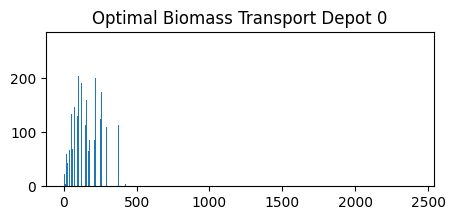

In [6]:
j = 0
year = 2018
cap_b_j = 20000 # Maximum depot capacity

# Get from all the positions to the position j=0
d_to_j = d_matrix.iloc[:, j].values
print("Distance to j=0: ", d_to_j)

# Get the forecasted biomass for year 2018 of all the positions
d_bio = df_fc.loc[:, str(year)]
d_bio = d_bio.to_dict()
print("Forecasted biomass for year 2018: ", d_bio)

# Get the solution for the optimization problem
m = Model()

# Variables: biomass b_{i, 0}
b = [m.add_var(name=f'b_{i}', lb=0) for i in range(len(d_to_j))]

# Constraints: 
# 1. Can't transport more than generated
for i in range(len(d_to_j)):
    m += b[i] <= d_bio[i]

# 2. Can't transport more than storage limit
m += xsum(b[i] for i in range(len(d_to_j))) == cap_b_j

# Objective function: distance to 0 * biomass
m.objective = minimize(xsum(d_to_j[i] * b[i] for i in range(len(d_to_j))))

# Solve the problem
m.max_gap = 0.05
status = m.optimize()

# Check the status and show the solutions
if status == OptimizationStatus.OPTIMAL:
    print('optimal solution cost {} found'.format(m.objective_value))
elif status == OptimizationStatus.FEASIBLE:
    print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
elif status in [OptimizationStatus.NO_SOLUTION_FOUND, OptimizationStatus.INFEASIBLE]:
    print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    # print('solution:')
    d_sol = {}
    for v in m.vars:
        d_sol.update({v.name: v.x})

print("Solution: ", d_sol)
df_sol = pd.DataFrame.from_dict(d_sol, orient='index', columns=['biomass'])
df_sol.to_csv(os.path.join(OUT_SYNTH_DATA_PATH, 'solution.csv'))

plt.figure(figsize=(5, 2))
plt.bar(range(len(d_to_j)), [v.x for v in m.vars])
plt.title('Optimal Biomass Transport Depot 0');

In [ ]:
def single_depot(d_matrix, n_depot, cap_depot, year=2018):
    # Get from all the positions to the position j=0
    d_to_j = d_matrix.iloc[:, n_depot].values
    print(f"Distance to j={n_depot}: {d_to_j}")

    # Get the forecasted biomass for year 2018 of all the positions
    d_bio = df_fc.loc[:, str(year)]
    d_bio = d_bio.to_dict()
    print("Forecasted biomass for year 2018: ", d_bio)

    # Get the solution for the optimization problem
    m = Model()

    # Variables: biomass b_{i, 0}
    b = [m.add_var(name=f'b_{i}', lb=0) for i in range(len(d_to_j))]

    # Constraints: 
    # 1. Can't transport more than generated
    for i in range(len(d_to_j)):
        m += b[i] <= d_bio[i]

    # 2. Can't transport more than storage limit
    m += xsum(b[i] for i in range(len(d_to_j))) == cap_depot

    # Objective function: distance to 0 * biomass
    m.objective = minimize(xsum(d_to_j[i] * b[i] for i in range(len(d_to_j))))

    # Solve the problem
    m.max_gap = 0.05
    status = m.optimize()

    # Check the status and show the solutions
    if status == OptimizationStatus.OPTIMAL:
        print('optimal solution cost {} found'.format(m.objective_value))
    elif status == OptimizationStatus.FEASIBLE:
        print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
    elif status in [OptimizationStatus.NO_SOLUTION_FOUND, OptimizationStatus.INFEASIBLE]:
        print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
    if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
        # print('solution:')
        d_sol = {}
        for v in m.vars:
            d_sol.update({v.name: v.x})

    print("Solution: ", d_sol)

    plt.figure(figsize=(5, 2))
    plt.bar(range(len(d_to_j)), [v.x for v in m.vars])
    plt.title(f'Optimal Biomass Transport Depot {n_depot}');

    return d_sol

d_sol = single_depot(d_matrix, 1, 20000)

# Second Approach: 2 depots

In a second approach, let's solve

$$
\min_{0\leq i \leq 2416} \sum_{i}(d_{i, 0} * b_{i, 0})*x_0 + \sum_{j}(d_{i, 1} * b_{i, 1}) * x_1\\
b_{i, j} \geq 0 \quad \forall j \in \{0, 1\}\\
\sum_i b_{i, j} \leq 20000\\
\sum_j b_{i, j} \leq b_{i}^{forecast}\\
\sum_j x_j = 1
$$

In [ ]:
pd.Series(d_bio).max()

In [ ]:
ls_j = [0, 1]
year = 2018
cap_b_j = 20000 # Maximum depot capacity

# Get from all the positions to the position j=0
# d_to_j = d_matrix.iloc[:, j].values
# print("Distance to j=0: ", d_to_j)

# Get the forecasted biomass for year 2018 of all the positions
d_bio = df_fc.loc[:, str(year)]
d_bio = d_bio.to_dict()
print("Forecasted biomass for year 2018: ", d_bio)

# Get the solution for the optimization problem
m = Model(sense=minimize)

# Variables: biomass b_{i, 0}
b = [m.add_var(name=f'b_{i}_{j}', lb=0) for i in range(len(d_matrix)) for j in ls_j]
x = [m.add_var(name=f'x_{j}', var_type=BINARY) for j in ls_j]

print(f"Variables b go from {b[0].name} to {b[-1].name}")
print(f"Variables x go from {x[0].name} to {x[-1].name}")

# Constraints:
# 1. Can't transport more than generated
for i in range(len(d_matrix)):
    m += xsum(m.var_by_name(f'b_{i}_{j}') for j in ls_j) <= d_bio[i]

# 2. Can't transport more than storage limit
for j in ls_j:
    m += xsum(m.var_by_name(f'b_{i}_{j}') for i in range(len(d_matrix))) == cap_b_j * x[j]

# 3. Where does the biomass go
m += xsum(x[j] for j in ls_j) == 1


m.objective = minimize(xsum(d_matrix.iloc[i, j] * m.var_by_name(f'b_{i}_{j}') for i in range(len(d_matrix)) for j in ls_j))

# Solve the problem
m.max_gap = 0.05
status = m.optimize()
print(status)
# Check the status and show the solutions
if status == OptimizationStatus.OPTIMAL:
    print('optimal solution cost {} found'.format(m.objective_value))
elif status == OptimizationStatus.FEASIBLE:
    print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
elif status in [OptimizationStatus.NO_SOLUTION_FOUND, OptimizationStatus.INFEASIBLE]:
    print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    # print('solution:')
    d_sol = {}
    for v in m.vars:
        d_sol.update({v.name: v.x})

print("Solution: ", d_sol)

# plt.figure(figsize=(5, 2))
# plt.bar(range(len(d_to_j)), [v.x for v in m.vars])
# plt.title('Optimal Biomass Transport Depot 0');

In [ ]:
status

In [17]:
ls_j = range(len(d_matrix))
year = 2018
cap_b_j = 20000 # Maximum depot capacity

# Get from all the positions to the position j=0
# d_to_j = d_matrix.iloc[:, j].values
# print("Distance to j=0: ", d_to_j)

# Get the forecasted biomass for year 2018 of all the positions
d_bio = df_fc.loc[:, str(year)]
d_bio = d_bio.to_dict()
print("Forecasted biomass for year 2018: ", d_bio)

# Get the solution for the optimization problem
m = Model(sense=minimize)

# Variables: biomass b_{i, 0}
b = [m.add_var(name=f'b_{i}_{j}', lb=0) for i in range(len(d_matrix)) for j in ls_j]
x = [m.add_var(name=f'x_{j}', var_type=BINARY) for j in ls_j]

print(f"Variables b go from {b[0].name} to {b[-1].name}")
print(f"Variables x go from {x[0].name} to {x[-1].name}")

# Constraints:
# 1. Can't transport more than generated
for i in range(len(d_matrix)):
    m += xsum(m.var_by_name(f'b_{i}_{j}') - d_bio[i] for j in ls_j) <= 0

# 2. Can't transport more than storage limit
for j in ls_j:
    m += xsum(m.var_by_name(f'b_{i}_{j}') for i in range(len(d_matrix))) <= cap_b_j * x[j]

# 3. Where does the biomass go
m += xsum(x[j] for j in ls_j) <= 25
m += xsum(x[j] for j in ls_j) >= 1

m.objective = minimize(xsum(d_matrix.iloc[i, j] * m.var_by_name(f'b_{i}_{j}') +\
                           (cap_b_j - m.var_by_name(f'b_{i}_{j}'))\
                            for i in range(len(d_matrix)) for j in ls_j))

# Solve the problem
m.max_gap = 0.05
status = m.optimize()
print(status)
# Check the status and show the solutions
if status == OptimizationStatus.OPTIMAL:
    print('optimal solution cost {} found'.format(m.objective_value))
elif status == OptimizationStatus.FEASIBLE:
    print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
elif status in [OptimizationStatus.NO_SOLUTION_FOUND, OptimizationStatus.INFEASIBLE]:
    print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    # print('solution:')
    d_sol = {}
    for v in m.vars:
        d_sol.update({v.name: v.x})

# print("Solution: ", d_sol)
df_sol = pd.DataFrame.from_dict(d_sol, orient='index', columns=['biomass'])
df_sol.to_csv(os.path.join(OUT_SYNTH_DATA_PATH, 'solution.csv'))

Forecasted biomass for year 2018:  {0: 7.387925148, 1: 40.43184662, 2: 59.18162918, 3: 74.53672028, 4: 16.53131485, 5: 23.59261703, 6: 37.77179718, 7: 72.29115295, 8: 31.31279564, 9: 36.00815201, 10: 7.731999874, 11: 4.729420662, 12: 4.019220352, 13: 0.170855775, 14: 0.407948494, 15: 29.41272354, 16: 94.71604919, 17: 128.6074066, 18: 119.6863556, 19: 60.41845703, 20: 82.89323425, 21: 90.87753296, 22: 116.8996277, 23: 109.9925232, 24: 87.78025055, 25: 77.210495, 26: 42.75498581, 27: 27.09572029, 28: 3.248904228, 29: 0.316811502, 30: 25.035532, 31: 87.5641098, 32: 150.813324, 33: 132.3540192, 34: 117.1153717, 35: 98.37117767, 36: 166.2753143, 37: 131.4788666, 38: 102.0719376, 39: 68.13217163, 40: 87.15248108, 41: 98.95579529, 42: 89.4603653, 43: 18.38335991, 44: 1.929136515, 45: 0.109720692, 46: 0.536449432, 47: 21.13311577, 48: 79.66234589, 49: 121.5448074, 50: 106.9424896, 51: 78.92514801, 52: 104.6953964, 53: 134.6973419, 54: 116.9567261, 55: 122.0452118, 56: 171.2545319, 57: 134.3496

In [15]:
d_sol

{'b_0_0': 110.81887721999996,
 'b_0_1': 0.0,
 'b_0_2': 0.0,
 'b_0_3': 0.0,
 'b_0_4': 0.0,
 'b_0_5': 0.0,
 'b_0_6': 0.0,
 'b_0_7': 0.0,
 'b_0_8': 0.0,
 'b_0_9': 0.0,
 'b_0_10': 0.0,
 'b_0_11': 0.0,
 'b_0_12': 0.0,
 'b_0_13': 0.0,
 'b_0_14': 0.0,
 'b_1_0': 0.0,
 'b_1_1': 606.4776992999999,
 'b_1_2': 0.0,
 'b_1_3': 0.0,
 'b_1_4': 0.0,
 'b_1_5': 0.0,
 'b_1_6': 0.0,
 'b_1_7': 0.0,
 'b_1_8': 0.0,
 'b_1_9': 0.0,
 'b_1_10': 0.0,
 'b_1_11': 0.0,
 'b_1_12': 0.0,
 'b_1_13': 0.0,
 'b_1_14': 0.0,
 'b_2_0': 0.0,
 'b_2_1': 0.0,
 'b_2_2': 887.7244376999998,
 'b_2_3': 0.0,
 'b_2_4': 0.0,
 'b_2_5': 0.0,
 'b_2_6': 0.0,
 'b_2_7': 0.0,
 'b_2_8': 0.0,
 'b_2_9': 0.0,
 'b_2_10': 0.0,
 'b_2_11': 0.0,
 'b_2_12': 0.0,
 'b_2_13': 0.0,
 'b_2_14': 0.0,
 'b_3_0': 0.0,
 'b_3_1': 0.0,
 'b_3_2': 0.0,
 'b_3_3': 1118.0508042000004,
 'b_3_4': 0.0,
 'b_3_5': 0.0,
 'b_3_6': 0.0,
 'b_3_7': 0.0,
 'b_3_8': 0.0,
 'b_3_9': 0.0,
 'b_3_10': 0.0,
 'b_3_11': 0.0,
 'b_3_12': 0.0,
 'b_3_13': 0.0,
 'b_3_14': 0.0,
 'b_4_0': 0.0,
 'b_4_1